In [118]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib
np.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


## Hierachical Gaussian Process Example
This is a simple example of a hierachical GP over a toy data set, the theory to do this is in  http://www.biomedcentral.com/1471-2105/14/252

Initially we generate a simple sinusoidal signal, which for our undertsanding is the parent signal.

### Parent signal generation

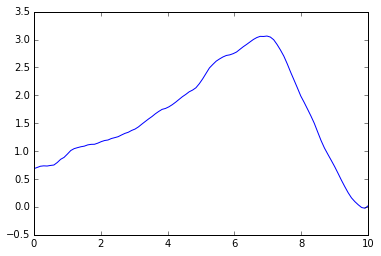

In [142]:
time_stamps = 100
x_parent = np.linspace(0, 10, time_stamps)
# generationg the parent form a GP sample
kg = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=4.0)
#inp = np.arange(x_parent.shape[0])
inp = x_parent[:, None]
C_parent_gen = kg.K(inp, None)
g_mean = np.zeros(x_parent.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
g_n = np.squeeze(g_n)
pb.plot(x_parent, g_n)

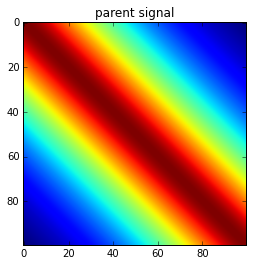

In [143]:
plt.imshow(C_parent_gen)

### Child signals generation
The we generate noise corrupted signals which are like "sons" from the original signal, to do this we only add to the original signal some  gaussian noise with mean zero and a standard deviation. We expect to recover the original signal using these as an input.

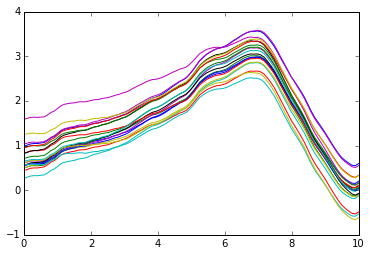

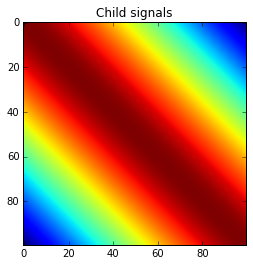

In [144]:
n_sons = 20
fn_list = []
kf = GPy.kern.Matern32(input_dim=1, variance=.1, lengthscale=10.0)
C_sons_gen = kf.K(inp, None)
plt.figure(1)
for i in range(0, n_sons):
    tmp = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    tmp = np.squeeze(tmp)
    fn_list.append(tmp)
    plt.plot(inp, tmp)

plt.figure(2)
plt.imshow(C_sons_gen)

The samples can be also generated simultaneosly marginalizing out the parent

In [145]:
def genSamplesSimul(kg, kf, inp, n_sons=3):
    T_hat = np.r_[np.c_[inp, np.zeros_like(inp)]]
    for i in range(1,n_sons):
        T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*i]]
        
    HGP_gen = GPy.kern._src.independent_outputs.Hierarchical(kernels=[kg,kf])
    HGP_cov_gen = HGP_gen.K(T_hat, None)
    plt.figure(1)
    plt.imshow(HGP_cov_gen)
    sample = np.random.multivariate_normal(np.zeros(T_hat.shape[0]), HGP_cov_gen)
    y_list = []
    plt.figure(2)
    for r in range(0,n_sons):
        index = T_hat[:,1]==r
        y_list.append(sample[index])
        plt.plot(inp, sample[index])
    return y_list

### Creating a Gp model to estimate paramaters

Given the documentation, the way to consruct a Hierarchical Kernel to compute a hierarchical covariance one need to use GPy.kern._src.independent_outputs.Hierarchical(kernels), Which receives as an input a list of kernels, the size of that list indicates the deepest level of that hierarchy, for these case we only have one level or layer.

The input to the regression is:
* T_hat: all data in the input space as a column vector with an extra column indicating the corresponding output
* y_hat: all data in the output space(sinusoidal corrupted signal) as a column vector.
* HGP: Hierarchical Kernel

Documentation(Code): https://github.com/SheffieldML/GPy/blob/devel/GPy/kern/src/independent_outputs.py 

In [146]:
T_hat = np.r_[np.c_[inp, np.zeros_like(inp)]]
#fn_list = genSamplesSimul(kg, kf, inp, n_sons)
Y_hat = np.r_[np.c_[fn_list[0]]]
for i in range(1,n_sons):
    T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*i]]
    Y_hat = np.r_[Y_hat, np.c_[fn_list[i]]]
    
k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.) # Kernel for the underlying trend
k2 = GPy.kern.Matern32(1, variance=2., lengthscale=10.) #+ GPy.kern.White(1, variance=0.0001) # Kernel for the layer of noise corrupted signals
#kernels = [k1,k2] 
HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels=[k1,k2])

In [147]:
model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
#print 'Model before op', model
#print 'hier kern before op', HGP
#model.optimize('bfgs')#, messages=1)
#print 'Model after op', model
#print 'hier kern after op', HGP

In [148]:
model.optimize_restarts(num_restarts = 20)

Optimization restart 1/20, f = -10141.187211
Optimization restart 2/20, f = -10089.1597665
Optimization restart 3/20, f = -9916.74469802
Optimization restart 4/20, f = -10139.8280694
Optimization restart 5/20, f = -10105.9772891
Optimization restart 6/20, f = -10141.7809472
Optimization restart 7/20, f = -9923.57551261
Optimization restart 8/20, f = -10134.4535575
Optimization restart 9/20, f = -10137.3926527
Optimization restart 10/20, f = -10100.5630271
Optimization restart 11/20, f = -8953.72851171
Optimization restart 12/20, f = -10074.9168209
Optimization restart 13/20, f = -10093.83181
Optimization restart 14/20, f = -10135.7164057
Optimization restart 15/20, f = -10132.3944487
Optimization restart 16/20, f = -10020.0674301
Optimization restart 17/20, f = -10138.8763037
Optimization restart 18/20, f = -10118.3995419
Optimization restart 19/20, f = -10102.7667506
Optimization restart 20/20, f = -9943.60430808


Inferring the posterior over the underlying function.

In [149]:
print k1
mu, mvar = model.predict(inp, kern=k1, full_cov=True)
diag_var = np.diag(mvar)
#model.hierarchy.Mat32_1.variance = kg.variance
#model.hierarchy.Mat32_1.lengthscale = kg.lengthscale
#model.hierarchy.Mat32.variance = kf.variance
#model.hierarchy.Mat32.lengthscale = kf.lengthscale
#print k1

  Mat32_1.     |      Value      |  Constraint  |  Prior  |  Tied to
  variance     |  5.23490761114  |     +ve      |         |         
  lengthscale  |  6.58519883539  |     +ve      |         |         


### predicting the upper layer

Mean of the posterior of the upper layer

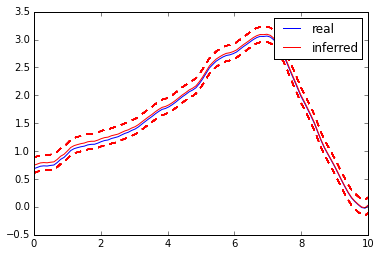

In [150]:
#mu2, mvar2 = model.predict(inp, kern=k1, full_cov=True)
#pb.plot(inp, g_n)
#pb.plot(inp, mu)
#pb.plot(inp, mu2)
blue_line, = pb.plot(inp, g_n, 'b-')
red_line, = pb.plot(inp, mu, 'r-')
pb.plot(inp, mu + 2*np.sqrt(diag_var), 'r--')
pb.plot(inp, mu - 2*np.sqrt(diag_var), 'r--')
plt.legend([blue_line, (blue_line, red_line)], ["real", "inferred"])

Covariance of the posterior compared to the one used to generate the data.

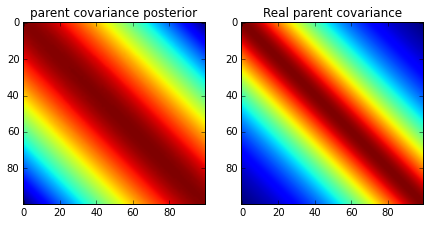

In [151]:
plt.figure(1, figsize=(15,6))
plt.subplot(1,4,1)
plt.title('parent covariance posterior')
plt.imshow(mvar)
#plt.subplot(1,4,2)
#plt.title('parent cov with origin params')
#plt.imshow(mvar2)
plt.subplot(1,4,2)
plt.title('Real parent covariance')
plt.imshow(C_parent_gen)

Plotting the model fitting


Name                              : GP regression
Log-likelihood                    : 4011.1035715
Number of Parameters              : 5
Number of Optimization Parameters : 5
Updates                           : True
Parameters:
  GP_regression.                 |        Value        |  Constraint  |  Prior  |  Tied to
  hierarchy.Mat32_1.variance     |      8.01954262041  |     +ve      |         |         
  hierarchy.Mat32_1.lengthscale  |      8.91261254656  |     +ve      |         |         
  hierarchy.Mat32.variance       |     0.080971149883  |     +ve      |         |         
  hierarchy.Mat32.lengthscale    |      9.26418669008  |     +ve      |         |         
  Gaussian_noise.variance        |  1.85127511019e-10  |     +ve      |         |         


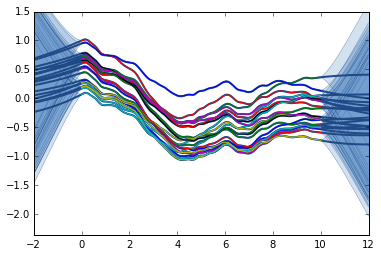

In [81]:
for i in range(n_sons):
        model.plot(fignum=1,fixed_inputs=[(1, i)], plot_raw=True)

for i in range(0, n_sons):
    pb.plot(inp, fn_list[i])

print model